In [8]:
import fenics as df
import numpy as np
import matplotlib.pyplot as plt

# Material parameters
Ms = 8.6e5  # saturation magnetisation (A/m)
alpha = 0.1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio
A = 1e-11 # exchange constant (J/m)

# External magentic field.
B = 0.1  # (T)
mu0 = 4 * np.pi * 1e-7  # vacuum permeability

# Zeeman field
H = Ms / 2 * df.Constant((0,1,0))
# meaningful time period is of order of nano seconds
dt = 1e-12
t_array = np.arange(0, 5e-9, dt)

############
# Simulation
############

# mesh parameters
d = 10e-9
thickness = 10e-9
nx = ny = 2
nz = 1

# create mesh
p1 = df.Point(0, 0, 0)
p2 = df.Point(d, d, thickness)
mesh = df.BoxMesh(p1, p2, nx, ny, nz)

# define function space for magnetization
V = df.VectorFunctionSpace(mesh, "CG", 1, dim=3)

# define initial M and normalise
m_init = df.Constant((1, 0, 0))
# define initial value
m = df.interpolate(m_init, V)
v = df.TestFunction(V)
volume = df.assemble(df.dot(v, df.Constant((1, 1, 1))) * df.dx).array()

def energy_density(m):
    w_Zeeman = - mu0 * Ms * df.dot(m, H)
    w_exchange = 0 #A  * df.inner(df.grad(m), df.grad(m))
    w = w_Zeeman + w_exchange
    return w

def effective_field(w, m, volume):
    dE_dm = - 1/mu0 * df.derivative(w / Ms * df.dx, m)
    # Heff =  0
    # Heff = df.assemble(dE_dm).array()/volume
    Heff = dE_dm
    return Heff

def LLG(Heff, m, c1=1, c2=1):
    tmp = df.project(Heff, V)
    return m
    #    return df.cross(m, Heff)
    
def turn_form_to_function(form, vectorspace):
    V = vectorspace
    u = df.TrialFunction(V)
    v = df.TestFunction(V)
    a = df.dot(u, v) * df.dx
    L = form * v 
    u_sol = df.Function(V)
    df.solve(a==L, u_sol)
    return u_sol
    
    
    
                            
    
w = energy_density(m)
Heff_form = effective_field(w, m, volume)
Heff = turn_form_to_function(Heff_form, V)
#llg = LLG(Heff, m)

#print m.vector().array(), Heff
print Heff



f_85


In [9]:
Heff.vector().array()

array([      0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,

In [10]:
dE_dm = - 1/mu0 * df.derivative(w / Ms * df.dx, m)

In [11]:
u = df.TrialFunction(V)

In [12]:
a = df.dot(u, v) * df.dx

u = df.Function(V)

L = dE_dm * v 

In [13]:
df.solve(a==L, u)

In [14]:
type(u)

dolfin.functions.function.Function

In [15]:
u.vector().array()

array([      0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.00000001,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,  430000.        ,       0.        ,
             0.        ,

In [16]:
type(w / Ms * df.dx)

ufl.form.Form

In [17]:
type(Heff)

dolfin.functions.function.Function

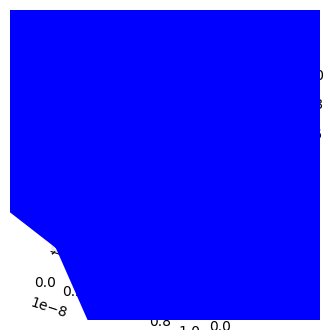

In [27]:
df.plot(Heff, interactive=True)

In [25]:
%matplotlib inline

In [21]:
import IPython

In [22]:
IPython.display?

In [23]:
df.X3DOM?

In [28]:
IPython.core.display.HTML(df.X3DOM.html(m))

In [33]:
HTML(df.X3DOM().html(u))

In [37]:
from IPython.display import HTML
HTML(df.X3DOM().html(m))

In [9]:
import dolfin as df
import time

mesh = df.UnitSquareMesh(2, 2)
print mesh
S1 = df.FunctionSpace(mesh, 'CG', 1)
S3 = df.VectorFunctionSpace(mesh, 'CG', 1, 3)
u = df.TrialFunction(S3)
v = df.TestFunction(S3)

m = df.Function(S3)  # magnetisation
Heff = df.Function(S3)  # effective field
Ms = df.Function(S1)  # saturation magnetisation
alpha = df.Function(S1)  # damping
gamma = df.Constant(1)  # gyromagnetic ratio

m.assign(df.Constant((1, 0, 0)))
Heff.assign(df.Constant((0, 0, 1)))
alpha.assign(df.Constant(1))
Ms.assign(df.Constant(1))

# just assembling it
LLG = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
L = df.dot(LLG, df.TestFunction(S3)) * df.dP

dmdt = df.Function(S3)
start = time.time()
for i in xrange(1000):
    df.assemble(L, tensor=dmdt.vector())
stop = time.time()
print "delta = ", stop - start
print dmdt.vector().array()

# more linear algebra, same problem... still need to assemble the cross product
# we're doing even more work than before
a = df.dot(u, v) * df.dP
A = df.assemble(a)
b = df.Function(S3)

dmdt = df.Function(S3)
start = time.time()
for i in xrange(2):
    df.assemble(L, tensor=b.vector())  # this is what should go out of the loop
    df.solve(A, dmdt.vector(), b.vector())  # some variation of this could stay in
stop = time.time()
print "delta = ", stop - start
print dmdt.vector().array()



<Mesh of topological dimension 2 (triangles) with 9 vertices and 8 cells, ordered>
delta =  0.738322019577
[ 0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5
  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5]
delta =  0.0020580291748
[ 0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5
  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5  0.   0.5  0.5]


In [10]:
m

In [11]:
Heff

In [12]:
type(m)

dolfin.functions.function.Function

In [13]:
type(Heff)

dolfin.functions.function.Function